### Take a look at SPY

In [1]:
from dateutil.relativedelta import relativedelta
from datetime import date
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
sns.set_style('whitegrid')

In [3]:
# read and plot SPY data

spy = pd.read_csv('../data/SPY.csv', index_col='Date',
                  usecols=['Date', 'Adj Close'], parse_dates=True)
spy.head()

,Adj Close
Date,
2020-03-03,294.735870
2020-03-04,307.124481
2020-03-05,296.915161
2020-03-06,292.006836
2020-03-09,269.202698


In [4]:
spy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2020-03-03 to 2021-03-02
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  252 non-null    float64
dtypes: float64(1)
memory usage: 3.9 KB


In [5]:
spy.describe()

,Adj Close
count,252.000000
mean,327.938196
std,40.435925
min,220.149750
25%,300.470612
50%,332.122329
75%,361.790314
max,392.640015


Text(0.5, 1.0, 'SPY')

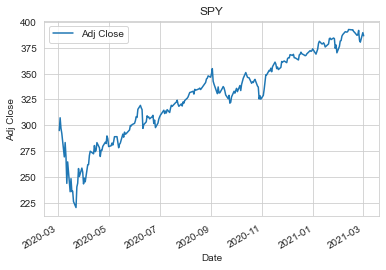

In [6]:
# plot SPY adjusted close

spy.plot()
plt.ylabel('Adj Close')
plt.title('SPY')

### Working with multiple stocks

In [7]:
def get_dates(window):
    '''
    Returns the index of date timestamps within the time window ending today

    Parameters:
    window (int): number of months

    Returns:
    dates (index): index of date timestamps within the time window ending today
    '''
    end_date = pd.to_datetime(date.today())
    start_date = pd.to_datetime(date.today() + relativedelta(months=-window))

    dates = pd.date_range(start_date, end_date)

    return dates

In [8]:
def get_data(symbols, window):
    '''
    Returns dataframe with adjusted closing values of the stocks specified in symbols within given time window

    Parameters:
    symbols (list): list of strings containing stock symbols
    window (int): number of months

    Returns:
    df (dataframe): dataframe with adjusted closing values of the stocks within specified time window
    '''

    dates = get_dates(window)
    df = pd.DataFrame(index=dates)

    # Add SPY to list of symbols if not already present. It is used as the benchmark.
    if 'SPY' not in symbols:
        symbols.insert(0, 'SPY')

    for symbol in symbols:
        df_stock = pd.read_csv('../data/{}.csv'.format(symbol), index_col='Date',
                               usecols=['Date', 'Adj Close'], parse_dates=True)
        df_stock.rename(columns={'Adj Close': symbol}, inplace=True)
        df = df.join(df_stock)

    df.dropna(subset=['SPY'], inplace=True)

    return df

In [9]:
def normalize(df):
    '''
    Returns normalized dataframe

    Parameters:
    df (dataframe): dataframe

    Returns:
    (dataframe): normalized dataframe
    '''
    return df / df.iloc[0]

In [10]:
def plot_data(df):
    '''
    Plots dataframe df's values

    Parameters:
    None

    Returns:
    None
    '''
    df.plot()
    plt.xlabel('Date')
    plt.ylabel('Adj Close')
    plt.title('Adj Close vs Date')

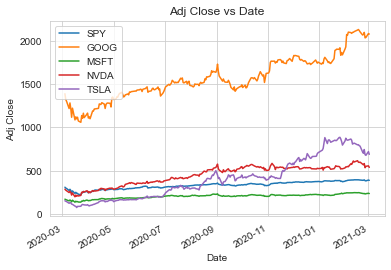

In [11]:
window = 12  # time window to look at data in months
symbols = ['GOOG', 'MSFT', 'NVDA', 'TSLA']

df = get_data(symbols, window)
plot_data(df)

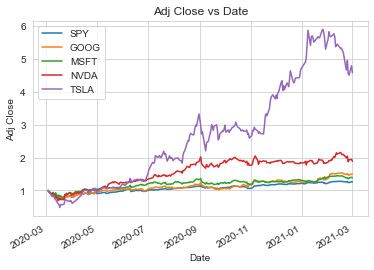

In [12]:
# look at normalized data

df_normalized = normalize(df)
plot_data(df_normalized)

### Bollinger bands

In [13]:
def get_rolling_mean(series, window=20):
    '''
    Return rolling mean of given values, using specified window size.

    Parameters:
    series (series): stock price
    window (int): window for rolling data

    Returns:
    (series): rolling mean
    '''
    return series.rolling(window).mean()


def get_rolling_std(series, window=20):
    '''
    Return rolling standard deviation of given values, using specified window size.

    Parameters:
    series (series): stock price
    window (int): window for rolling data

    Returns:
    (series): rolling standard deviation
    '''
    return series.rolling(window).std()


def get_bollinger_bands(series, window=20):
    '''
    Return upper and lower Bollinger Bands.

    Parameters:
    series (series): stock price
    window (int): window for rolling data

    Returns:
    upper_band (series): upper bollinger band
    lower_band (series): lower bollinger band
    '''
    rolling_mean = get_rolling_mean(series, window)
    rolling_std = get_rolling_std(series, window)
    lower_band = rolling_mean - 2 * rolling_std
    upper_band = rolling_mean + 2 * rolling_std
    return upper_band, lower_band


def plot_bollinger_bands(symbol, window=20, df=df):
    '''
    Plots stock price, rolling mean and Bollinger Bands for given symbol using window provided

    Parameters:
    symbol (str): Stock symbol
    window (int): Window for rolling data
    df (dataframe): Dataframe containing stock price data

    Returns:
    None
    '''
    ax = df[symbol].plot()
    upper_band, lower_band = get_bollinger_bands(df[symbol], window)
    upper_band.plot(color='orange', ax=ax)
    lower_band.plot(color='orange', ax=ax)
    get_rolling_mean(df[symbol], window).plot(color='orange', ls=':', ax=ax)
    plt.xlabel('Date')
    plt.ylabel('Adj Close')
    plt.title('Adj Close vs Date for {}'.format(symbol))

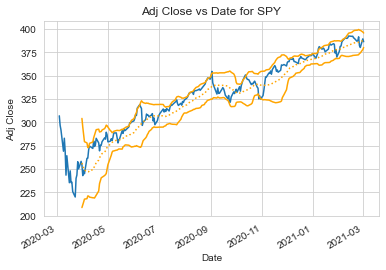

In [14]:
plot_bollinger_bands('SPY')

### Daily and cumulative returns

In [15]:
def compute_daily_returns(df):
    '''
    Compute and return the daily returns.

    Parameters:
    df (dataframe): Dataframe containing stock price data

    Returns:
    daily_returns (dataframe): Daily returns of the stock prices in dataframe df
    '''
    daily_returns = df.copy()
    daily_returns[1:] = (daily_returns[1:] / daily_returns[:-1].values) - 1
    daily_returns.iloc[0, :] = 0
    return daily_returns


def compute_cumulative_return(df):
    '''
    Compute and return the cumulative return values.

    Parameters:
    df (dataframe): Dataframe containing stock price data

    Returns:
    cumulative_returns (dataframe): Cumulative returns of the stock prices in dataframe df
    '''
    cumulative_returns = df.iloc[-1] / df.iloc[0] - 1
    return cumulative_returns


def plot_daily_return(symbol, df=df):
    '''
    Plot daily returns.

    Parameters:
    symbol (str): Stock symbol
    df (dataframe): Dataframe containing stock price data

    Returns:
    None
    '''

    daily_returns = compute_daily_returns(df[symbol])
    daily_returns.plot()
    plt.xlabel('Date')
    plt.ylabel('Daily Return')
    plt.title('Daily Returns for {}'.format(symbol))
    plt.axhline(daily_returns.mean(), color='orange', ls='-', lw=2)
    plt.axhline(daily_returns.std(), color='orange', ls='--', lw=2)
    plt.axhline(-daily_returns.std(), color='orange', ls='--', lw=2)

    print(f'Kurtosis: {daily_returns.kurtosis()}')


def plot_daily_return_hist(symbol, bins=20, df=df):
    '''
    Plot daily returns histogram.

    Parameters:
    symbol (str): Stock symbol
    bins (int): Number of histogram bins
    df (dataframe): Dataframe containing stock price data

    Returns:
    None
    '''
    daily_returns = compute_daily_returns(df[symbol])
    daily_returns.hist(bins=bins)
    plt.xlabel('Daily Return')
    plt.title('Daily Returns for {} histogram'.format(symbol))
    plt.axvline(daily_returns.mean(), color='orange', ls='-', lw=2)
    plt.axvline(daily_returns.std(), color='orange', ls='--', lw=2)
    plt.axvline(-daily_returns.std(), color='orange', ls='--', lw=2)

    print(f'Kurtosis: {daily_returns.kurtosis()}')

In [16]:
# Cumulative return for all stocks in the dataframe df
compute_cumulative_return(df)

SPY     0.258578
GOOG    0.497158
MSFT    0.385204
NVDA    0.886801
TSLA    3.579320
dtype: float64

Kurtosis: 8.277164667453812


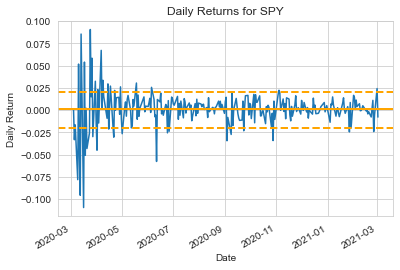

In [17]:
# Plot daily returns for SPY
plot_daily_return('SPY')

Kurtosis: 8.277164667453812


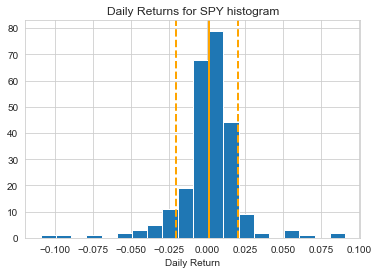

In [18]:
# Plot daily returns for SPY histogram
plot_daily_return_hist('SPY')

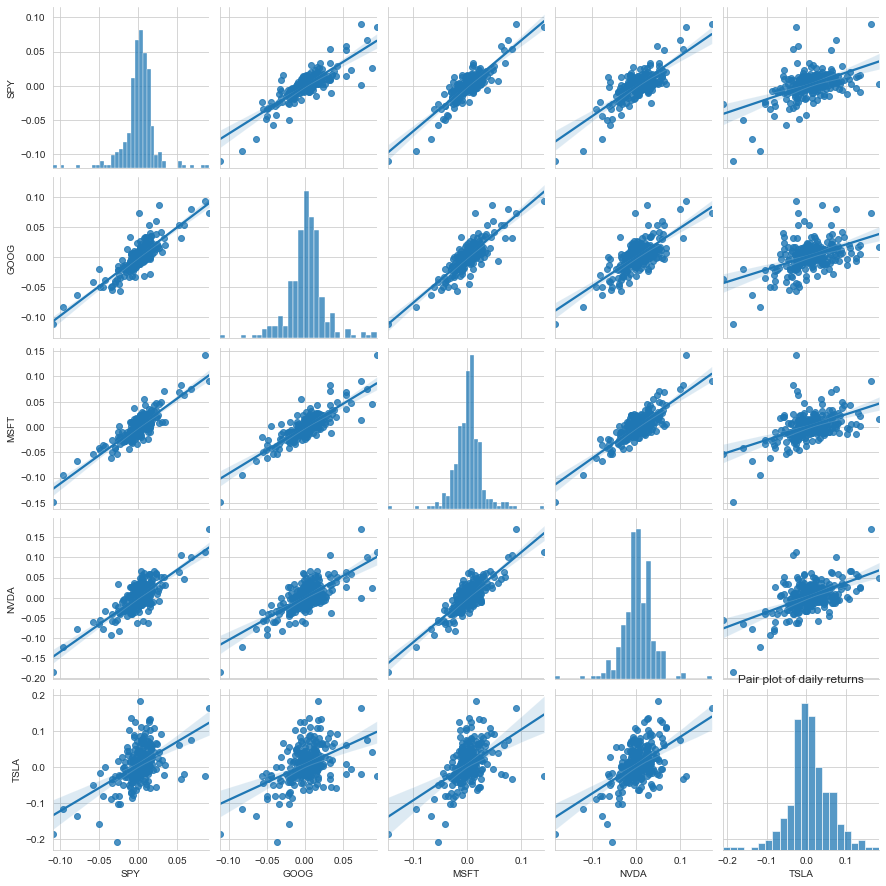

In [19]:
# Pair plot of daily returns
sns.pairplot(compute_daily_returns(df), kind='reg')
plt.title('Pair plot of daily returns');

In [21]:
# Compare 'TSLA' performance to 'SPY'
daily_returns = compute_daily_returns(df)
beta_TSLA, alpha_TSLA = np.polyfit(daily_returns['SPY'], daily_returns['TSLA'], 1)
print(f'Beta: {beta_TSLA}, Alpha: {alpha_TSLA}')

Beta: 1.291975323116524, Alpha: 0.006017870044553029


### Portfolio statistics

In [41]:
# Set up portfolio
companies = ['TSLA', 'MSFT']
allocation = [0.2, 0.8]
stock_prices = df[companies]
norm_stock_prices = normalize(stock_prices)
allocated_stock_prices = norm_stock_prices * allocation

In [42]:
# Returns for an investment made
investment = 1000
investment_stock_prices = allocated_stock_prices * investment

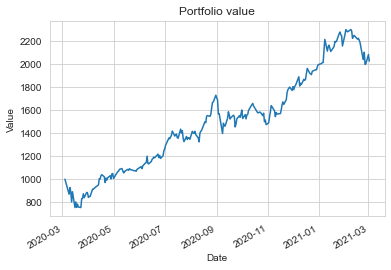

In [49]:
# Portfolio value over time plot
portfolio_value = investment_stock_prices.sum(axis=1)
portfolio_value.plot()
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Portfolio value');

In [67]:
# Portfolio stats
portfolio_daily_rets = compute_daily_returns(portfolio_value).iloc[1:]
portfolio_cum_rets = compute_cumulative_return(portfolio_value)
avg_daily_ret = portfolio_daily_rets.mean()
std_daily_ret = portfolio_daily_rets.std()

risk_free_return_rate = 0.0002
K = np.sqrt(252)
sharpe_ratio = K * ((portfolio_daily_rets - risk_free_return_rate).mean() / (portfolio_daily_rets - risk_free_return_rate).std())

In [68]:
sharpe_ratio

1.61073307751535